# Load packages

In [1]:
import numpy as np
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import nltk, re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [2]:
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#nltk.download('punkt')

stopword = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

# Read the data

In [3]:
os.listdir(".")

['.ipynb_checkpoints',
 'movie-reviews-eda.ipynb',
 'movie-reviews-eda.py',
 'test.csv',
 'test.csv.zip',
 'test_pandas_20190930.py',
 'test_pandas_20191001.py',
 'train.csv',
 'train.csv.zip']

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

## Check the data

In [5]:
train_df.head()

,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text,polarity
0,0,tt0400837,Snuff killer - La morte in diretta,Snuff killer - La morte in diretta,0.0,"Horror,Thriller",2003,NaN,88.0,A cheap exploitation film about a mothers sear...,0
1,1,tt0036038,In Old Oklahoma,In Old Oklahoma,0.0,"Romance,Western",1943,NaN,102.0,John Wayne & Albert Dekker compete for oil rig...,0
2,2,tt0493430,Jackass Number Two,Jackass Number Two,0.0,"Action,Comedy,Documentary",2006,NaN,92.0,This film tops the previous incarnation by a m...,1
3,3,tt0089603,Mishima: A Life in Four Chapters,Mishima: A Life in Four Chapters,0.0,"Biography,Drama",1985,NaN,120.0,"The only pure life, is one that ends with a si...",1
4,4,tt0427038,Carlito's Way: Rise to Power,Carlito's Way: Rise to Power,0.0,"Action,Crime,Drama",2005,NaN,100.0,"really awful... lead actor did OK... the film,...",0


In [6]:
test_df.head()

,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text
0,20000,tt0402910,Chaos,Chaos,0.0,"Action,Crime,Drama",2005,NaN,106.0,"those people,who told me""this movie is good""-s..."
1,20001,tt0088959,Criminally Insane 2,Criminally Insane 2,0.0,"Horror,Thriller",1987,NaN,70.0,Nick Millard aka Nick Phillips should have lef...
2,20002,tt0088983,The Dagger of Kamui,Kamui no ken,0.0,"Action,Adventure,Animation",1985,NaN,132.0,"When I saw this movie at age 6, it was in the ..."
3,20003,tt0376263,Tough Luck,Tough Luck,0.0,Thriller,2003,NaN,88.0,"Not having heard of this film, it came as a su..."
4,20004,tt0026273,The Desert Trail,The Desert Trail,0.0,"Action,Adventure,Romance",1935,NaN,54.0,"Falsely accused, skirt-chasing chums John Wayn..."


In [7]:
print(f"Datase shape: train: {train_df.shape}; test: {test_df.shape}")

Datase shape: train: (20000, 11); test: (27000, 10)


## Missing data

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(train_df)

,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text,polarity
Total,0,0,0,0,0,0,0,19090,240,0,0
Percent,0,0,0,0,0,0,0,95.45,1.2,0,0
Types,int64,object,object,object,float64,object,int64,float64,float64,object,int64


In [10]:
missing_data(test_df)

,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text
Total,0,0,0,0,0,0,0,25727,320,0
Percent,0,0,0,0,0,0,0,95.2852,1.18519,0
Types,int64,object,object,object,float64,object,int64,float64,float64,object


Missing data are ~5% of `end_year` in both train and test as well as ~1% `runtime_minutes`.

# Data exploration

In [11]:
def plot_features_distribution(features, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(df[feature]),kde=True,hist=False, bins=120, label=feature)
        else:
            sns.distplot(df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 

stopwords = set(STOPWORDS)

def show_wordcloud(feature,df):
    data = df.loc[~df[feature].isnull(), feature].values
    count = (~df[feature].isnull()).sum()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle("Prevalent words in {} ({} rows)".format(feature,count), fontsize=20)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

def show_confusion_matrix(valid_y, predicted, size=1, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

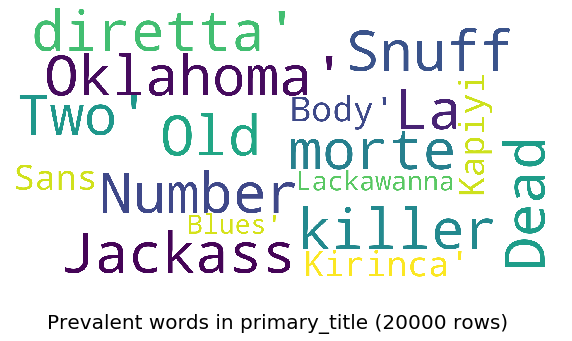

In [12]:
show_wordcloud('primary_title', train_df)

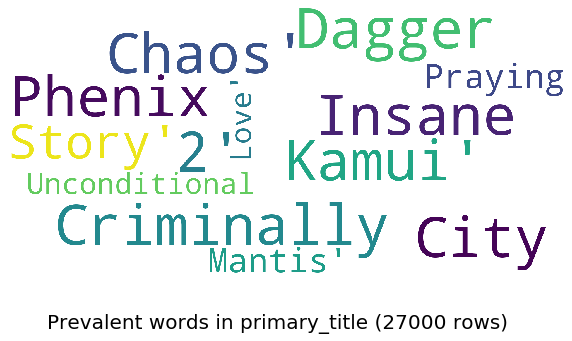

In [13]:
show_wordcloud('primary_title', test_df)

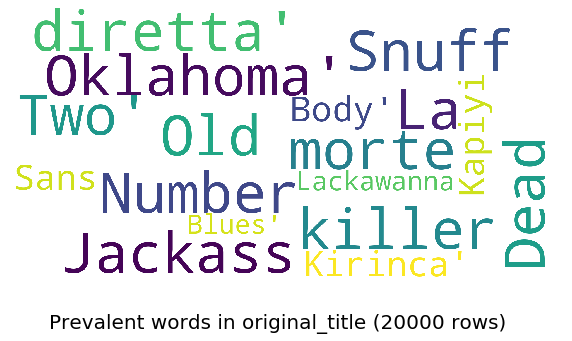

In [14]:
show_wordcloud('original_title', train_df)

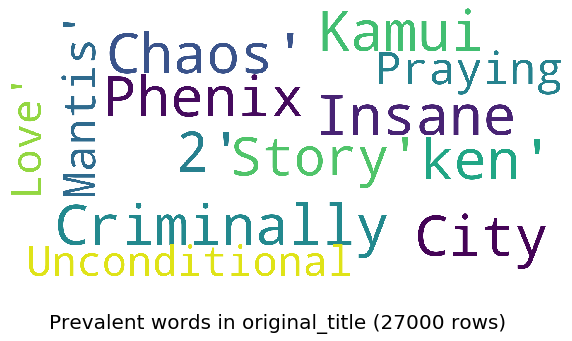

In [15]:
show_wordcloud('original_title', test_df)

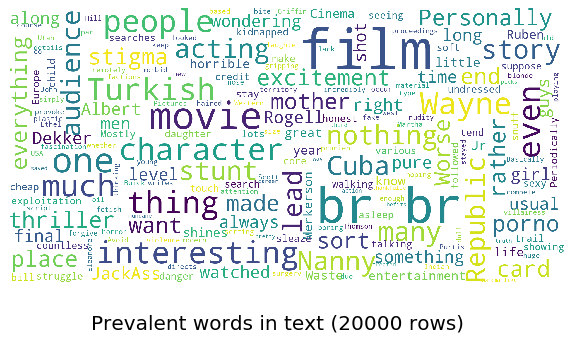

In [16]:
show_wordcloud('text', train_df)

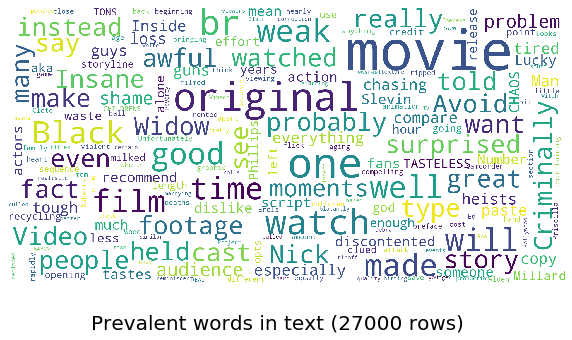

In [17]:
show_wordcloud('text', test_df)

D:\utils\Continuum\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\utils\Continuum\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


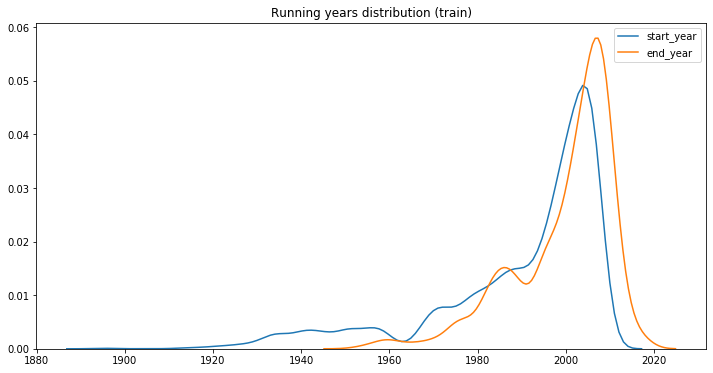

In [18]:
plot_features_distribution(['start_year', 'end_year'], 'Running years distribution (train)', train_df)

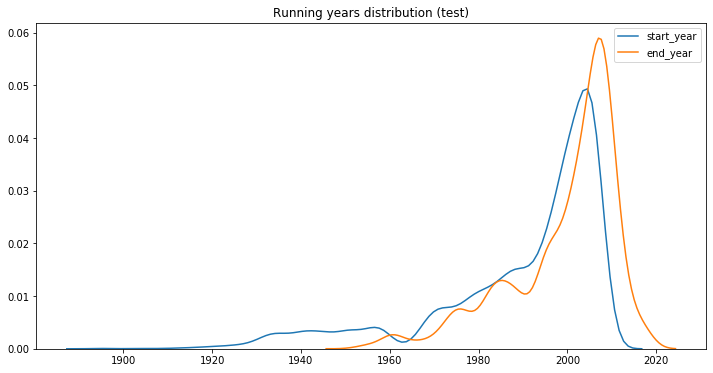

In [19]:
plot_features_distribution(['start_year', 'end_year'], 'Running years distribution (test)', test_df)

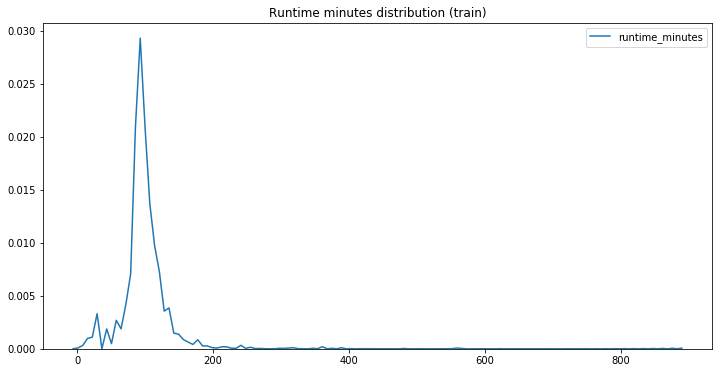

In [20]:
plot_features_distribution(['runtime_minutes'], 'Runtime minutes distribution (train)', test_df)

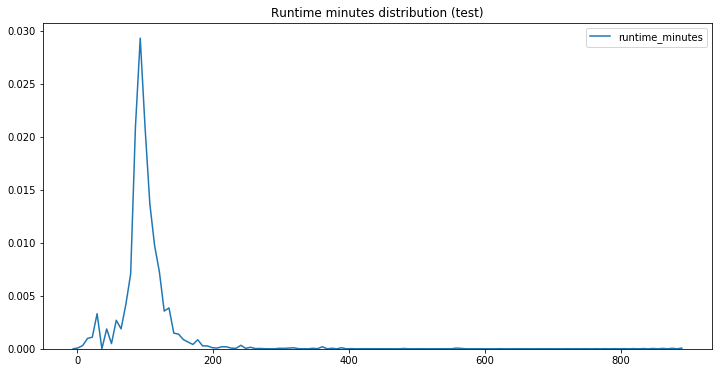

In [21]:
plot_features_distribution(['runtime_minutes'], 'Runtime minutes distribution (test)', test_df)

In [22]:
print(f"Movies in train: {train_df.title_id.nunique()} and test: {test_df.title_id.nunique()}")
l1 = set(train_df.title_id.unique())
l2 = set(test_df.title_id.unique())
card_int = len(l1.intersection(l2))
print(f"Common movies in train & test: {card_int}")

Movies in train: 5286 and test: 5839
Common movies in train & test: 4484


Only one movie is common between `train` and `test`.

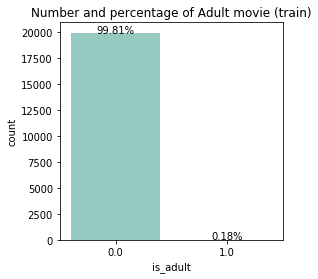

In [23]:
plot_count('is_adult', 'Adult movie (train)', train_df, size=1)

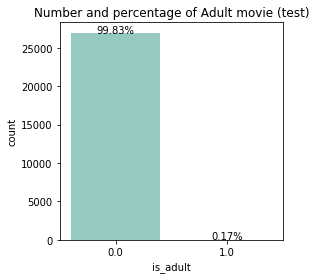

In [24]:
plot_count('is_adult', 'Adult movie (test)', test_df, size=1)

# Data cleaning

In [31]:
def expand_contractions(text, cs_dict):
  contractions_pattern = re.compile('({})'.format('|'.join(cs_dict.keys())), flags=re.IGNORECASE | re.DOTALL)

  def expand_match(contraction):
    match = contraction.group(0)
    expanded_contraction = cs_dict.get(match) if cs_dict.get(match) else cs_dict.get(match.lower())
    return expanded_contraction

  expanded_text = contractions_pattern.sub(expand_match, text)
  expanded_text = re.sub("'", "", expanded_text)
  expanded_text = re.sub('"', "", expanded_text)
  return expanded_text

def pre_process(txt):
  contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he had",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I had",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "iit will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that had",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they had",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
  }

  ptext = re.sub('<[^<]+?>','',txt.lower())
  ptext=expand_contractions(ptext,contractions_dict)
  wdtk = nltk.word_tokenize(ptext)
  rwords = [snowball_stemmer.stem(word) for word in wdtk if word not in stopword and word not in punctuation and not word.isdigit()]

  return " ".join(rwords)

In [27]:
train_df.text = train_df.text.apply(np.vectorize(pre_process))

D:\utils\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [32]:
test_df.text = test_df.text.apply(np.vectorize(pre_process))

# Baseline model

We will create a very simple model using only review text data, based on Count vectorizer, without text data pre-processing.

In [34]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                             ngram_range=(1, 1),
                             stop_words='english')
    X_feature = cv.fit_transform(df[feature])
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature


In [35]:
data = pd.concat([train_df, test_df])

D:\utils\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [36]:
data.shape

(47000, 11)

In [37]:
X_feature = count_vect_feature('text', data, max_features=5000)

Count Vectorizer `text` completed in 7.88 sec.


In [38]:
X = X_feature[0:train_df.shape[0]]
X_test = X_feature[train_df.shape[0]:]
y = train_df.polarity.values
print(f"X: {X.shape} test X: {X_test.shape} y: {y.shape}")
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
print(f"train X: {train_X.shape}, valid X: {valid_X.shape}, train y: {train_y.shape}, valid y: {valid_y.shape}")

X: (20000, 5000) test X: (27000, 5000) y: (20000,)
train X: (14000, 5000), valid X: (6000, 5000), train y: (14000,), valid y: (6000,)


In [39]:
clf = MultinomialNB(fit_prior=True)

In [40]:
clf.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

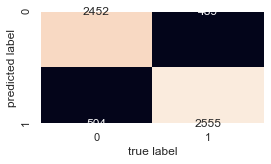

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2956
           1       0.84      0.84      0.84      3044

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



In [41]:
predicted_valid = clf.predict(valid_X)
show_confusion_matrix(valid_y, predicted_valid, size=1)
print(classification_report(valid_y, predicted_valid))

Let's calculate the validation score using the metric for this competition, ROC-AUC:

In [42]:
print(f"ROC-AUC: {roc_auc_score(predicted_valid, valid_y)}")

ROC-AUC: 0.8344851492004851


# Submission

Let's predict the polarity for the test set.

In [43]:
predict_test = clf.predict(X_test)

In [46]:
submission = pd.read_csv('./sampleSubmission.csv')
submission['polarity'] = predict_test
submission.to_csv('submission.csv', index=False)

# Further improvements

* Pre-process the text data: clean contraction, clean special characters, eliminate stop words, use lematization or stemming;
* Use different text vectorizing options;
* Use other models;
* Add additional features (categorical or numerical);
* Perform model tuning
